In [66]:
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import random
# from numpy import NaN
from pylab import rcParams

from functions import *        # import functions from the .py file

rcParams["figure.figsize"] = 16, 4

# Step 1: hello world

## Recording

you can also open the usb port. Example on macos `/dev/tty.usbmodem101`

In [57]:
PORT = '/dev/tty.usbmodem2101' # TODO: Add your port 

In [39]:
filename = f"capture_hello_world.log"
RECORD_TIME = 10

record_data(PORT, filename, RECORD_TIME)

00:00:19.525 | 0f 1c 01 50 25 53 2c 4c 30 94 2b ea 1f 91 16 ab | -70 CRC error

00:00:20.025 | 0f 1d 01 5c 22 c3 26 a3 21 26 23 34 24 9b 28 e6 | -70 CRC error

00:00:20.525 | 0f 1e 01 68 19 d1 29 b7 22 c3 13 a2 19 89 19 3f | -72 CRC error

00:00:21.025 | 0f 1f 01 74 13 fa 2e 11 1f 06 1c 62 27 56 25 68 | -72 CRC error

00:00:21.525 | 0f 20 01 80 24 0e 1d 94 23 52 1a ec 11 6f 21 0b | -71 CRC error

00:00:22.025 | 0f 21 01 cc 68 3d 2d 35 1f 9a 1f c8 15 bb 23 8b | -69 CRC error

00:00:22.525 | 0f 22 20 98 1e 7f 2f 7a 2c 16 2b 3f 1b 48 20 f0 | -72 CRC error

00:00:23.025 | 0f 23 01 a4 27 aa 23 0e 1f 07 1f fb 13 92 21 82 | -71 CRC error

00:00:23.525 | 0f 24 01 b0 24 f0 20 2e 1e bc 18 3d 14 b3 23 28 | -70 CRC error

00:00:24.025 | 0f 25 01 bc 1c 41 13 af 20 61 21 60 11 14 16 d0 | -70 CRC error

00:00:24.525 | 0f 26 01 c8 13 42 22 4a 27 f1 0e ec 26 1b 28 d6 | -70 CRC error

00:00:25.025 | 0f 27 01 d4 25 68 1c 00 2b a1 1d 15 26 f9 2a 38 | -70 CRC error

00:00:25.525 | 0f 28 01 e0 21 b3 1f 87 2

**Packet format**

`timestamp_rx |  len [hex] seq [hex] payload [hex] | rssi`
<br>$\text{ len [hex]}$ = payload length + 1 (seq. field length [1B])
<br>$\text{ payload [hex]}$ should start with the pseudo sequence number [2B], indicates the starting byte's position in the file.

`CRC error` is just a dummy string to be compatible with the output of TI RF Studio 
***
*Example log file output for one frame with reciever timestamp xxxx, frame length, seq number and random payload, received signal strength.*
<br>15:17:18.394 |0f 46 bd f8 f7 ea 41 ac 1b be 05 a0 7f d2 09 d4 |  -91 CRC error
<br>$\color{red}{\text{delimiter for four variables is "|" and delimiter for the payload each byte is the space " ".}}$

# Step 2: set parameters

In [58]:
PAYLOADSIZE = 14
if PAYLOADSIZE % 2 != 0:
    print("Alarm! the payload size is not even.")
NUM_16RND = (PAYLOADSIZE-2)//2 # how many 16 bits random number included in each frame
MAX_SEQ = 256 # (decimal) maximum seq number defined by the length of the seq, the length of seq is 1B

## Configuration of the board

In [59]:
carrier = 2450000000  # carrier frequency
clock = 125000000     # clock of the RPi Pico
div0 = 20             # clock divider to create a frequency shift for f_0
div1 = 18             # clock divider to create a frequency shift for f_1

shift= int((clock/div0 + clock/div1)/2)
deviation = int((clock/div1 - clock/div0)/2)
center = carrier + shift
baud = 50000
bandwidth = baud + 2*deviation

print(f"center:{center/1e9}GHz")
print(f"shift:{shift/1e3}kHz, deviation:{deviation/1e3}kHz")
print(f"baud:{baud}, bandwdith:{bandwidth/1e3}kHz")

configure_board(PORT, div0, div1, baud, deviation, center, bandwidth)

center:2.456597222GHz
shift:6597.222kHz, deviation:347.222kHz
baud:50000, bandwdith:744.444kHz
b 20 18 50000
c 2456597222 347222 50000 744444


## Recording of received data into a log file

In [65]:
filename = f"capture_{center}_{deviation}_{baud}_{bandwidth}.log"
RECORD_TIME = 10

record_data(PORT, filename, RECORD_TIME) 

KeyboardInterrupt: 

## Load and inspect log

In [44]:
df = pd.DataFrame(columns=['timestamp', 'payload', 'rss'])

# import file to jupyter notebook
df = readfile("./" + filename)
# check the imported data first 10 lines

# delete packets of invalid length (aka. error in length field at variable receiver length config) (PAYLOADSIZE + 2B pesudo sequence number)
df_clean = df[df.payload.apply(lambda x: len(x)==((PAYLOADSIZE)*3-1))]
df_clean.reset_index(inplace=True)

df_clean.head(10)

,level_0,index,time_rx,rssi,seq,payload
0,0,0,2025-02-07 00:00:55.775,-70,104,04 e0 2b 90 1e 8e 23 4e 1c b6 28 64 17 20
1,1,1,2025-02-07 00:00:56.275,-70,105,04 ec 19 9e 1c 55 22 1c 24 b4 19 ed 14 db
2,2,2,2025-02-07 00:00:56.775,-70,106,04 f8 1f 76 1f 8c 22 66 27 74 35 9c 28 95
3,3,3,2025-02-07 00:00:57.275,-71,107,05 04 26 2f 1b d0 1d b9 12 c0 13 32 1e d4
4,4,4,2025-02-07 00:00:57.775,-71,108,05 10 28 29 31 05 2c 0e 29 08 20 91 20 ed
5,5,5,2025-02-07 00:00:58.275,-70,109,05 1c 23 03 1b bb 22 0e 2c 27 25 b0 13 d5
6,8,8,2025-02-07 00:00:59.775,-71,112,05 40 33 47 15 b3 22 98 22 8a 22 05 10 41
7,9,9,2025-02-07 00:01:00.275,-70,113,05 4c 17 5f 29 8a 23 44 28 f9 21 70 2f c3
8,10,10,2025-02-07 00:01:00.775,-70,114,05 58 21 5b 1a 1e 25 95 14 f5 17 40 21 d6
9,11,11,2025-02-07 00:01:01.275,-70,115,05 64 28 be 2a a5 1c 45 25 17 22 88 1a 48


# Performance analysis

**Delay**
<br>*File Transmission Time: the total latency that certain amount of Data $F$ is delivered to the destination.*
<br> $File\ Delay = Rx\_timestamp[N] - Rx\_timestamp[0]$
<br> where $N$ is the last packet
***
**Interesting to look at**:
<br>*Timestamp difference*: $\Delta T[i] = Rx\_timestamp[i] - Tx\_timestamp[i]$
1. *Worst-case packet delay*: the delay of the packet that takes the longest time to traverse.
2. *Packet delay variation*: the std of the packet delay.

In [45]:
# delay

file_delay = performance_time(df)
file_delay_s = np.timedelta64(file_delay, "ms").astype(int) / 1000
print(f"You received {len(df_clean)} packets in {file_delay_s} seconds.")

You received 19 packets in 10.0 seconds.


**Reliability**
<br>*Quality of data transfer.*
<br>*Bit Reliability*: The ratio of data bits correctly delivered to the data sink.
<br>*Bit Error Rate*: The ratio of data bits incorrectly delivered to the data sink.
$$Bit\ Reliability = 1 - BER = 1 - \frac{Number\ of\ wrong\ bit}{Total\ Number\ of\ bit\ received}$$
<br>*Achieved Data Rate*: The bit error rate is calculated based on the received data only. Missing packets do not affect the bit error rate, but are reflected in the achievable data rate.

Bit error rate [%]: 0.14097744		(in received packets within pseudo sequence + payload) 
Note: if individual packets have a high bit-error rate, it could be that the pseudo-sequence number was corrupted and the script could not identify the expected payload correctly.


[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

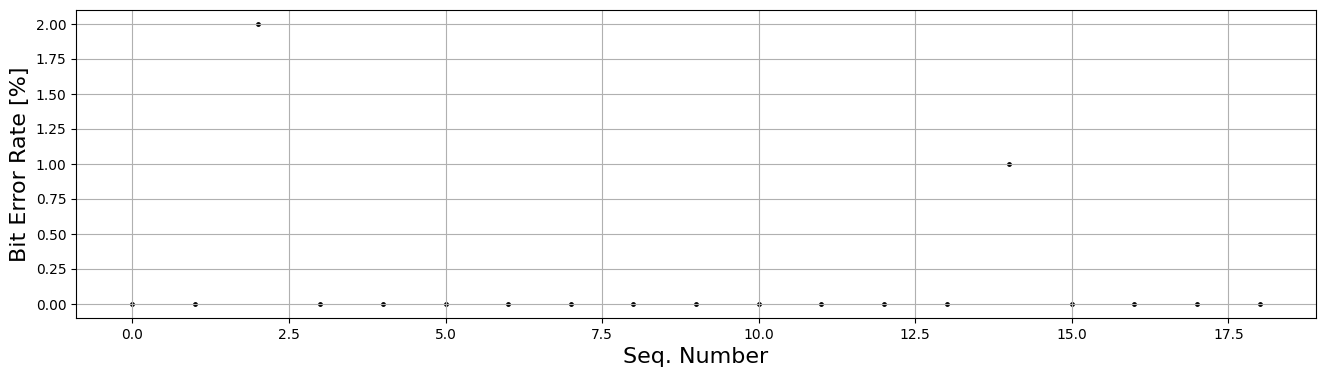

In [46]:
# reliability

ber = performance_ber(df_clean, NUM_16RND)
bit_reliability = (1-ber)*100
print(f"Bit error rate [%]: {(ber*100):.8f}\t\t(in received packets within pseudo sequence + payload) ")

analysis_ber_packet(df_clean, NUM_16RND)

**The communication distance of the system.**
<br>$D_{1}$: the distance between carrier<->backscatter_tag[m]
<br>$D_{2}$: the distance between backscatter_tag<->receiver[m]
<br> Distance metric = $D_{1}^2D_{2}^2$
<br>

In [47]:
# distance

dis_metric = performance_distance(1, 4) # param1: distance_carrier_tag, param2: distance_tag_rx
print(f"Distance metric is: {dis_metric}")

Distance metric is: 16


## Radarplot

**Please pay attention to the unit**
<br> <font color='red'>Time</font>: use second as unit
<br> <font color='red'>Reliability</font>: use the percent as unit
<br> <font color='red'>Distance</font>: use meter as unit
<br>**Metics = [Time(s), Reliability(%), Distance(m)]**
<br> <font color='red'>Always keep the reference in your plot.</font>
<br> Tips: for ploting, time metric uses $\frac{1}{Time}*1000$ as the time metric, the higher the value the better the system performance

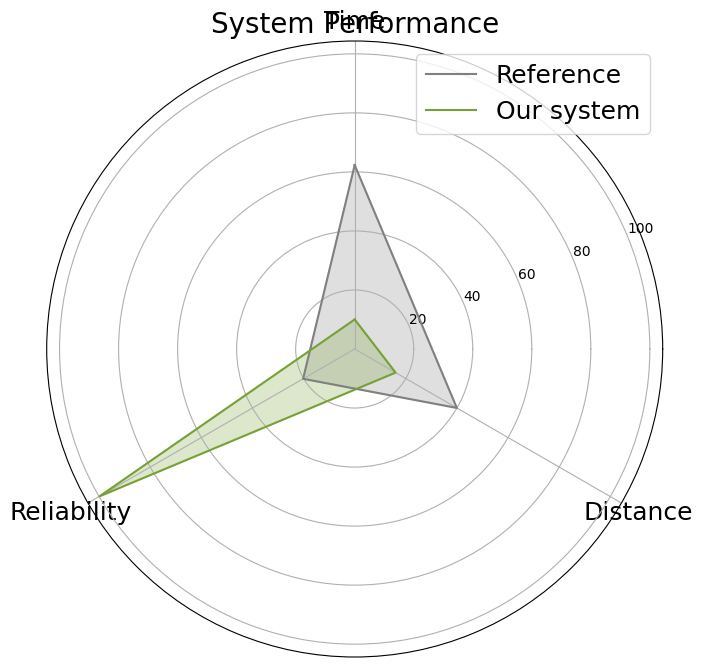

In [52]:
metrics = [file_delay_s, bit_reliability, dis_metric]
radar_plot(metrics)

# Step 3: bit error rate vs. frequency shift

In [55]:
carrier = 2450000000  # carrier frequency
clock = 125000000     # clock of the RPi Pico

# configuration with different shifts but similar deviation (at least for 1,2,4 MHz)
config = {
    "conf1": {"div0": 20, "div1": 18, "baud": 50000},   # shift 6.5 MHz
    "conf2": {"div0": 24, "div1": 22, "baud": 50000},   # shift 5.5 MHz
    "conf3": {"div0": 28, "div1": 24, "baud": 50000},   # shift 5 MHz
    "conf4": {"div0": 30, "div1": 26, "baud": 50000},   # shift 4.5 MHz
    "conf5": {"div0": 34, "div1": 30, "baud": 50000}    # shift 4 MHz
}

x = []
y = []

for key in config.keys():
    print(key)

    # --- configure the board
    div1 = config[key]["div0"]
    div2 = config[key]["div1"]

    shift= int((clock/div1 + clock/div2)/2)
    deviation = int((clock/div2 - clock/div1)/2)
    center = carrier + shift
    baud = config[key]["baud"]
    bandwidth = baud + 2*deviation

    print(f"center:{center/1e9} GHz")
    print(f"shift:{shift/1e3} kHz, deviation:{deviation/1e3} kHz")
    print(f"baud:{baud}, bandwdith:{bandwidth/1e3}kHz")
      
    configure_board(PORT, div1, div2, baud, deviation, center, bandwidth)

    # --- collect data
    filename = f"capture_{center}_{deviation}_{baud}_{bandwidth}.log"
    RECORD_TIME = 10
    record_data(PORT, filename, RECORD_TIME)    

    # --- load log file
    df = pd.DataFrame(columns=['timestamp', 'payload', 'rss'])

    # import file to jupyter notebook
    df = readfile("./" + filename)

    # delete packets of invalid length (aka. error in length field at variable receiver length config) (PAYLOADSIZE + 2B pesudo sequence number)
    df_clean = df[df.payload.apply(lambda x: len(x)==((PAYLOADSIZE)*3-1))]
    df_clean.reset_index(inplace=True)

    # --- performance analysis
    # delay
    file_delay = performance_time(df)
    file_delay_s = np.timedelta64(file_delay, "ms").astype(int) / 1000

    # reliability
    ber = performance_ber(df_clean, NUM_16RND)
    bit_reliability = (1-ber)*100

    print(f"ber:{ber}")
    
    # prepare arrays for plot
    x.append(shift)
    y.append(deviation)
    
plt.plot(x, y)

conf1
center:2.456597222 GHz
shift:6597.222 kHz, deviation:347.222 kHz
baud:50000, bandwdith:744.444kHz
b 20 18 50000
c 2456597222 347222 50000 744444


KeyboardInterrupt: 

# Step 4: do you own analysis

Copy to above cell and vary different parameters (eg, frequency deviation or baud rate)